In [28]:
## Import Packages
import numpy as np
import _pickle as pk
import AA as aa
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [29]:
Source = '/Users/johnvirgin/OneDrive - University of Waterloo/Papers/GMD_CanESM/'

In [30]:
#load in cloud feedbacks and dimensions as needed
data_sw = {}
data_lw = {}

mods = ['CanESM2','CanESM5_p2']

for i in range(2):
    data_sw[mods[i]] = pk.load(open(Source+\
        'Data/'+mods[i]+'/CFMIP/Tier 1/'+mods[i]+'_CFMIP_TrCLsw_FB_SRdecomp_Grid.pi','rb'))
    data_lw[mods[i]] = pk.load(open(Source+\
        'Data/'+mods[i]+'/CFMIP/Tier 1/'+mods[i]+'_CFMIP_TrCLlw_FB_SRdecomp_Grid.pi','rb'))

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat,(lon.size,1)).T

In [36]:
land_mask = np.isnan(np.mean(pk.load(\
    open(Source+'Data/CanESM2/Climatology/CanESM2_SST_Climo.pi','rb')),axis=0))
land_valid = np.isfinite(np.mean(pk.load(\
    open(Source+'Data/CanESM2/Climatology/CanESM2_SST_Climo.pi','rb')),axis=0))

dSST = {}
dSST_gam = {}
for i in range(len(mods)):
    dSST[mods[i]] = pk.load(open(\
        Source+'Data/'+mods[i]+'/CFMIP/Tier 1/'+mods[i]+'_dSST.pi','rb'))
    
    dSST_gam[mods[i]] = {}
    for exp in dSST[mods[i]].keys():
        dSST[mods[i]][exp] = np.nanmean(dSST[mods[i]][exp],axis=0)
        dSST[mods[i]][exp][land_mask == True] = np.nan
        
        dSST_gam[mods[i]][exp] = np.average(\
            dSST[mods[i]][exp][land_valid],weights=coslat[land_valid])
        
        
dSST_plot = {}
for mod in dSST.keys():
    dSST_plot[mod] = {}
    for exp in dSST[mod].keys():
        dSST_plot[mod][exp] = np.concatenate((dSST[mod][exp][:,64:],dSST[mod][exp][:,0:64]),axis=1)
        dSST_plot[mod][exp],lon_cyc = add_cyclic_point(dSST_plot[mod][exp],lon)

In [24]:
data_sw_plot = dict()
data_lw_plot = dict()
data_lw_gam = dict()
data_sw_gam = dict()
for mods in data_sw.keys():
    data_sw_plot[mods] = dict()
    data_lw_plot[mods] = dict()
    
    data_sw_gam[mods] = dict()
    data_lw_gam[mods] = dict()
    
    for prop in data_sw[mods].keys():
        data_sw_plot[mods][prop] = dict()
        data_lw_plot[mods][prop] = dict()
        
        data_sw_gam[mods][prop] = dict()
        data_lw_gam[mods][prop] = dict()
        
        for exp in data_sw[mods][prop].keys():
            data_sw_gam[mods][prop][exp] = np.average(np.nanmean(\
            data_sw[mods][prop][exp],axis=0),weights=coslat)
            data_lw_gam[mods][prop][exp] = np.average(np.nanmean(\
            data_lw[mods][prop][exp],axis=0),weights=coslat)
            
            data_sw_plot[mods][prop][exp] = np.nanmean(np.concatenate((\
            data_sw[mods][prop][exp][:,:,64:],data_sw[mods][prop][exp][:,:,0:64]),axis=2),axis=0)
            
            data_sw_plot[mods][prop][exp],lon_cyc = add_cyclic_point(\
            data_sw_plot[mods][prop][exp],lon)
            
            data_lw_plot[mods][prop][exp] = np.nanmean(np.concatenate((\
            data_lw[mods][prop][exp][:,:,64:],data_lw[mods][prop][exp][:,:,0:64]),axis=2),axis=0)
            
            data_lw_plot[mods][prop][exp],lon_cyc = add_cyclic_point(\
            data_lw_plot[mods][prop][exp],lon)

In [25]:
FB_bounds = np.arange(-8,8.1,1)
FB_bounds_ticks = np.arange(-8,8.1,2)
cmap = plt.cm.RdBu_r
FB_norm = mpl.colors.BoundaryNorm(FB_bounds, cmap.N)

dFB_bounds = np.arange(-4,4.1,0.5)
dFB_bounds_ticks = np.arange(-4,4.1,1)
dFB_norm = mpl.colors.BoundaryNorm(dFB_bounds, cmap.N)

SST_bounds = np.arange(-2.25,2.26,0.25)
SST_bounds_ticks = np.arange(-2.5,2.6,0.5)
cmap = plt.cm.RdBu_r
SST_norm = mpl.colors.BoundaryNorm(SST_bounds, cmap.N)

dSST_bounds = np.arange(-1,1.1,0.1)
dSST_bounds_ticks = np.arange(-1,1.1,0.2)
dSST_norm = mpl.colors.BoundaryNorm(dSST_bounds, cmap.N)

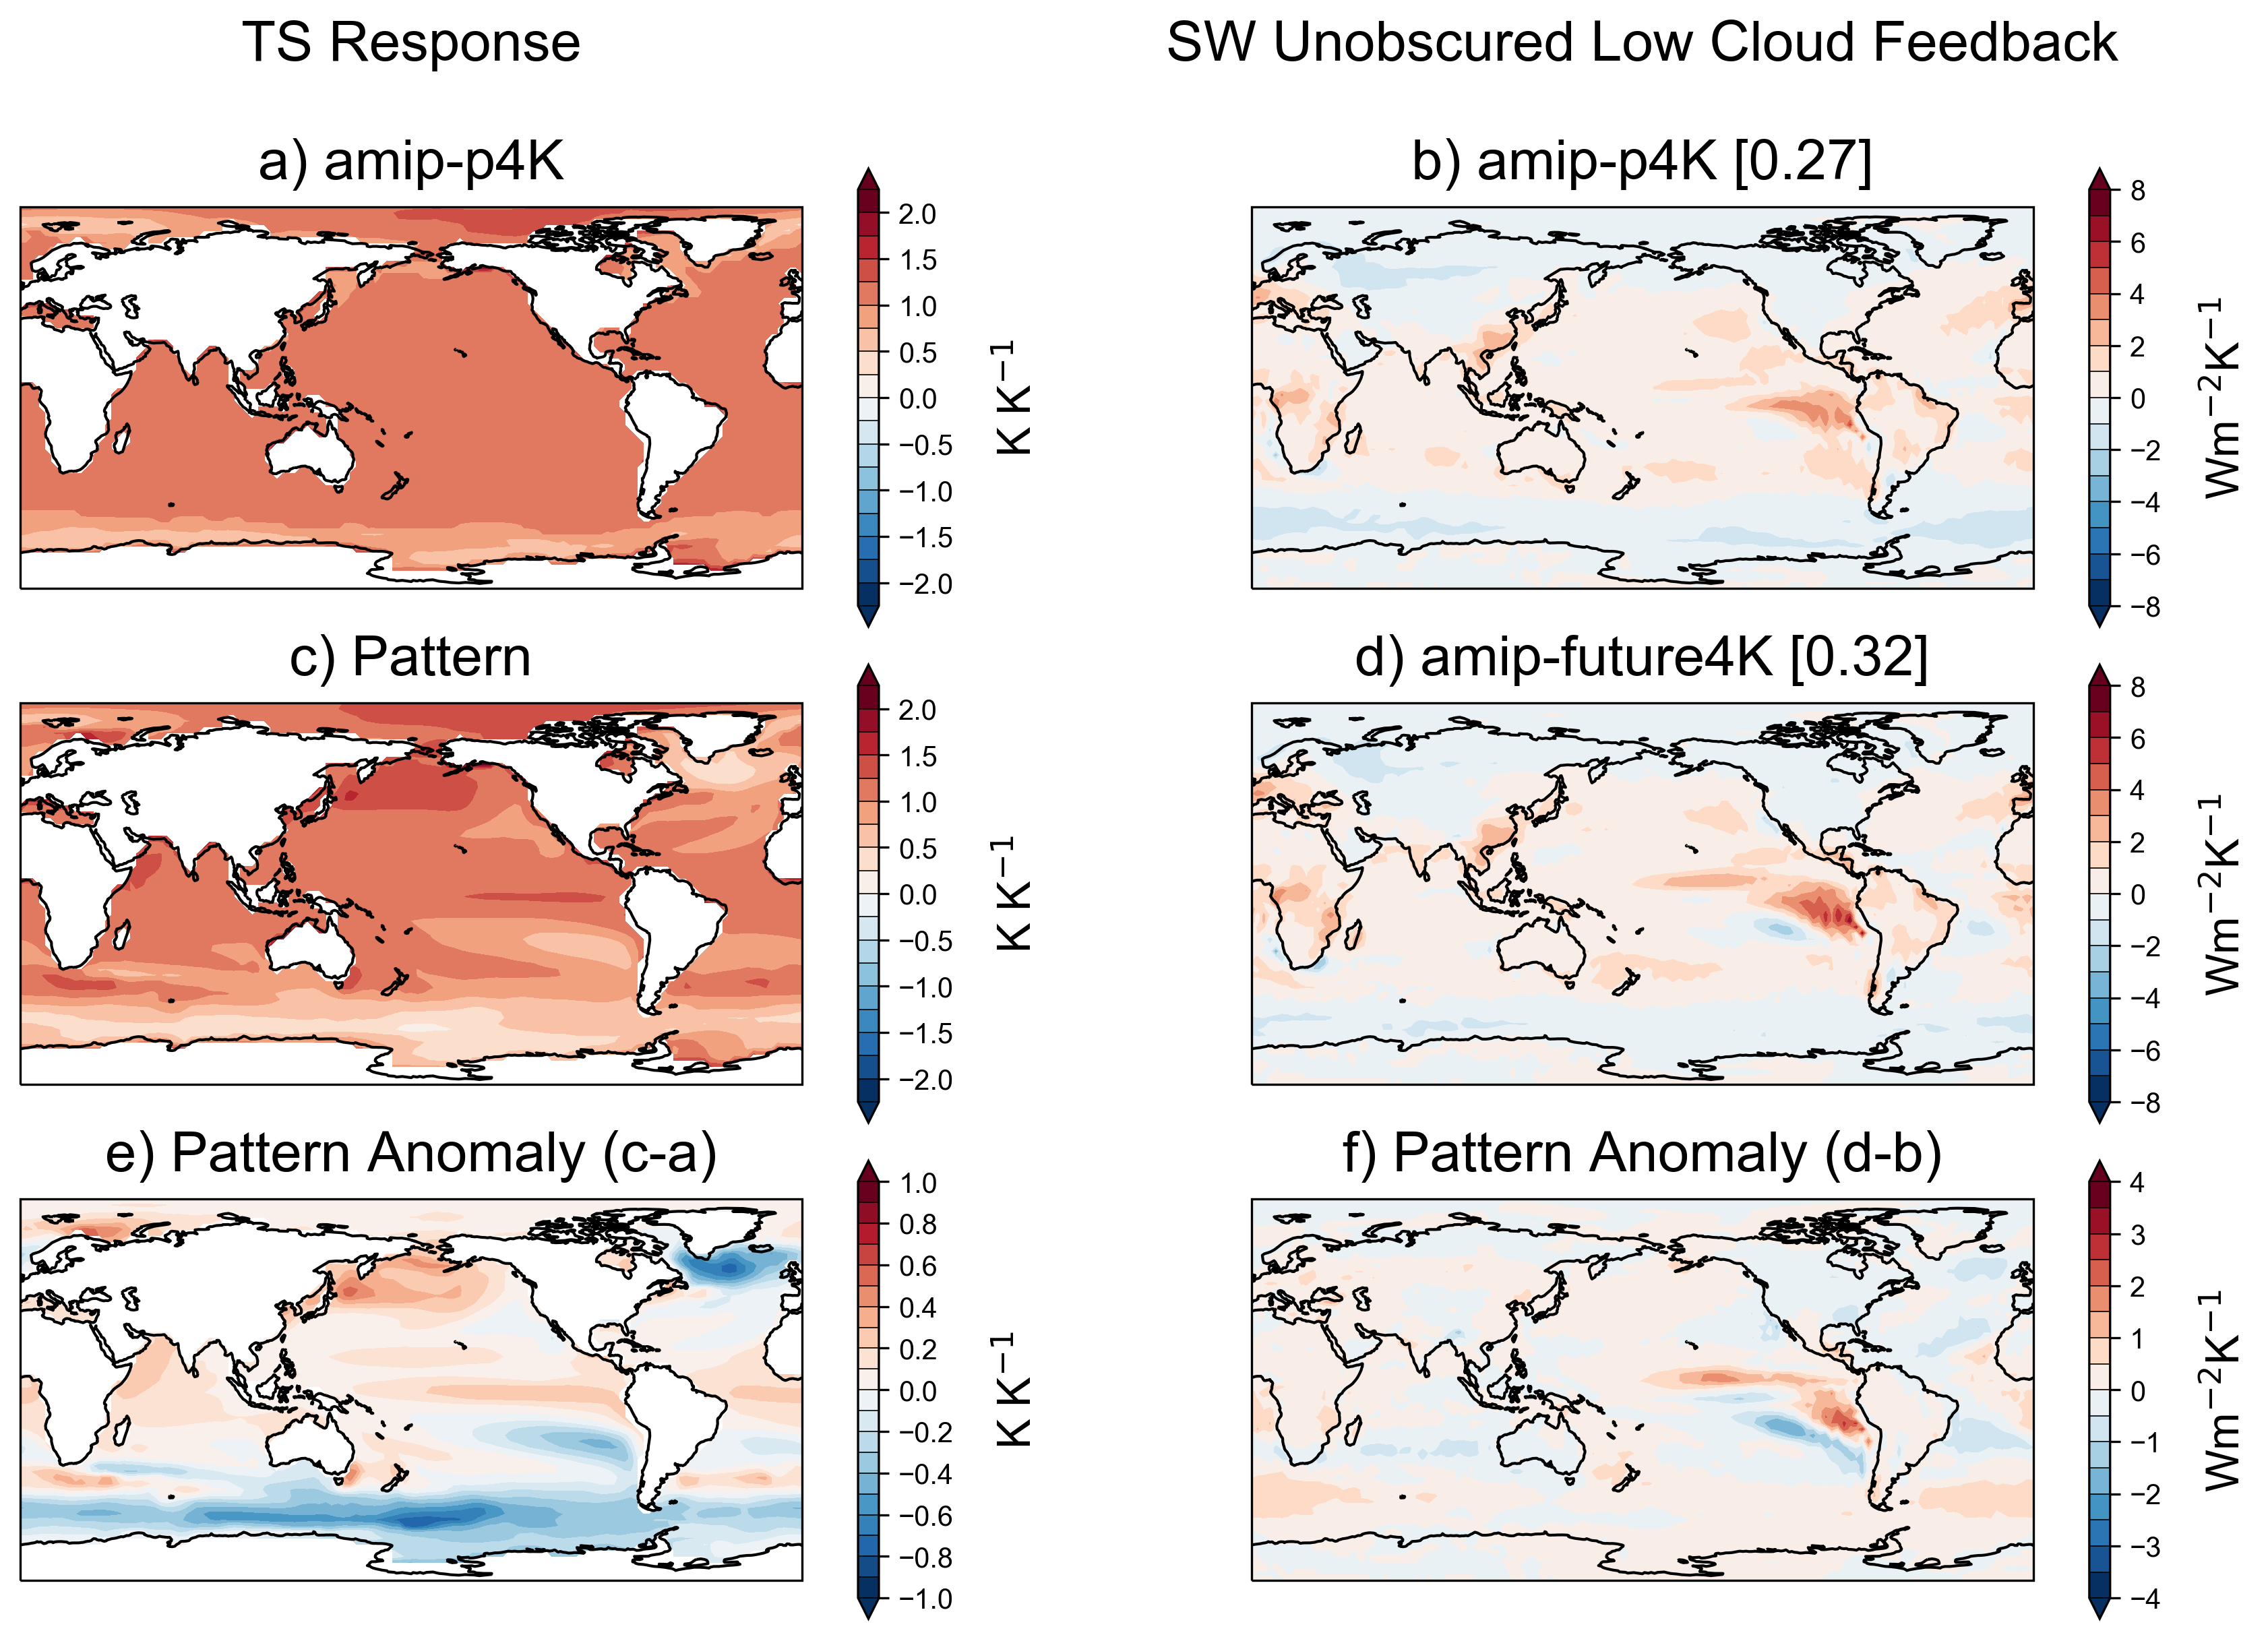

In [41]:
fig = plt.figure(figsize=(15,9),dpi=300)

#Uniform SST change
ax = plt.subplot(321,projection=ccrs.PlateCarree(central_longitude=180))
#ax.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax.set_title('TS Response\n\na) amip-p4K',fontsize=20,pad=10)
im = ax.contourf(lon_cyc,lat,\
    dSST_plot['CanESM2']['Uniform']/dSST_gam['CanESM2']['Uniform'],\
                   SST_bounds,cmap=cmap,norm=SST_norm,extend='both')
ax.coastlines()
cbar_1 = plt.colorbar(im,ticks=SST_bounds_ticks,drawedges=True,shrink=1.2)
cbar_1.set_label('K K$^{-1}$',labelpad=15,fontsize=16)
#plt.text(0.15,1.3,'2SST',fontsize=20,transform = ax.transAxes)

#Uniform SW Cloud amount feedback
ax1 = plt.subplot(322,projection=ccrs.PlateCarree(central_longitude=180))
#ax1.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax1.set_title('SW Unobscured Low Cloud Feedback\n\nb) amip-p4K [{}]'.\
              format(round(data_sw_gam['CanESM2']['Low_unobscured']['amip-p4K'],2)),\
              fontsize=20,pad=10)
im1 = ax1.contourf(lon_cyc,lat,data_sw_plot['CanESM2']['Low_unobscured']['amip-p4K'],\
                   FB_bounds,cmap=cmap,norm=FB_norm,extend='both')
ax1.coastlines()
cbar_1 = plt.colorbar(im1,ticks=FB_bounds_ticks,drawedges=True,shrink=1.2)
cbar_1.set_label('Wm$^{-2}$K$^{-1}$',labelpad=15,fontsize=16)
#plt.text(0.2,1.3,'5SST',fontsize=40,transform = ax1.transAxes)

#Pattern SST change
ax2 = plt.subplot(323,projection=ccrs.PlateCarree(central_longitude=180))
#ax2.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax2.set_title('c) Pattern',fontsize=20,pad=10)
im2 = ax2.contourf(lon_cyc,lat,\
    dSST_plot['CanESM2']['Pattern']/dSST_gam['CanESM2']['Pattern'],\
                   SST_bounds,cmap=cmap,norm=SST_norm,extend='both')
ax2.coastlines()
cbar_2 = plt.colorbar(im2,ticks=SST_bounds_ticks,drawedges=True,shrink=1.2)
cbar_2.set_label('K K$^{-1}$',labelpad=15,fontsize=16)
#plt.text(0.15,1.3,'2SST',fontsize=20,transform = ax.transAxes)

#Pattern SW Cloud amount feedback
ax3 = plt.subplot(324,projection=ccrs.PlateCarree(central_longitude=180))
#ax3.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax3.set_title('d) amip-future4K [{}]'.\
              format(round(data_sw_gam['CanESM2']['Low_unobscured']['amip-future4K'],2)),fontsize=20,pad=10)
im3 = ax3.contourf(lon_cyc,lat,data_sw_plot['CanESM2']['Low_unobscured']['amip-future4K'],\
                   FB_bounds,cmap=cmap,norm=FB_norm,extend='both')
ax3.coastlines()
cbar_3 = plt.colorbar(im3,ticks=FB_bounds_ticks,drawedges=True,shrink=1.2)
cbar_3.set_label('Wm$^{-2}$K$^{-1}$',labelpad=15,fontsize=16)  

#Pattern SST change
ax4 = plt.subplot(325,projection=ccrs.PlateCarree(central_longitude=180))
#ax4.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax4.set_title('e) Pattern Anomaly (c-a)',fontsize=20,pad=10)
im4 = ax4.contourf(lon_cyc,lat,\
    (dSST_plot['CanESM2']['Pattern']/dSST_gam['CanESM2']['Pattern'])\
    -(dSST_plot['CanESM2']['Uniform']/dSST_gam['CanESM2']['Uniform']),\
                   dSST_bounds,cmap=cmap,norm=dSST_norm,extend='both')
ax4.coastlines()
cbar_4 = plt.colorbar(im4,ticks=dSST_bounds_ticks,drawedges=True,shrink=1.2)
cbar_4.set_label('K K$^{-1}$',labelpad=15,fontsize=16)

#Pattern SW Cloud amount feedback
ax5 = plt.subplot(326,projection=ccrs.PlateCarree(central_longitude=180))
#ax5.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax5.set_title('f) Pattern Anomaly (d-b)',fontsize=20,pad=10)
im5 = ax5.contourf(lon_cyc,lat,(data_sw_plot['CanESM2']['Low_unobscured']['amip-future4K']-\
                   data_sw_plot['CanESM2']['Low_unobscured']['amip-p4K']),\
                   dFB_bounds,cmap=cmap,norm=dFB_norm,extend='both')
ax5.coastlines()
#g = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='k', linestyle='-')
#g.xlabels_top = False
#g.xlabels_bottom = False
#g.ylabels_left = False
#g.ylabels_right = False
#g.xlines = False
#g.ylocator = mticker.FixedLocator([-30, 30])
cbar_5 = plt.colorbar(im5,ticks=dFB_bounds_ticks,drawedges=True,shrink=1.2)
cbar_5.set_label('Wm$^{-2}$K$^{-1}$',labelpad=15,fontsize=16) 


plt.subplots_adjust(wspace=0.1,hspace=0.3)

#plt.savefig('CLD_Custom_5SST_CLDfb.png',bbox_inches='tight')

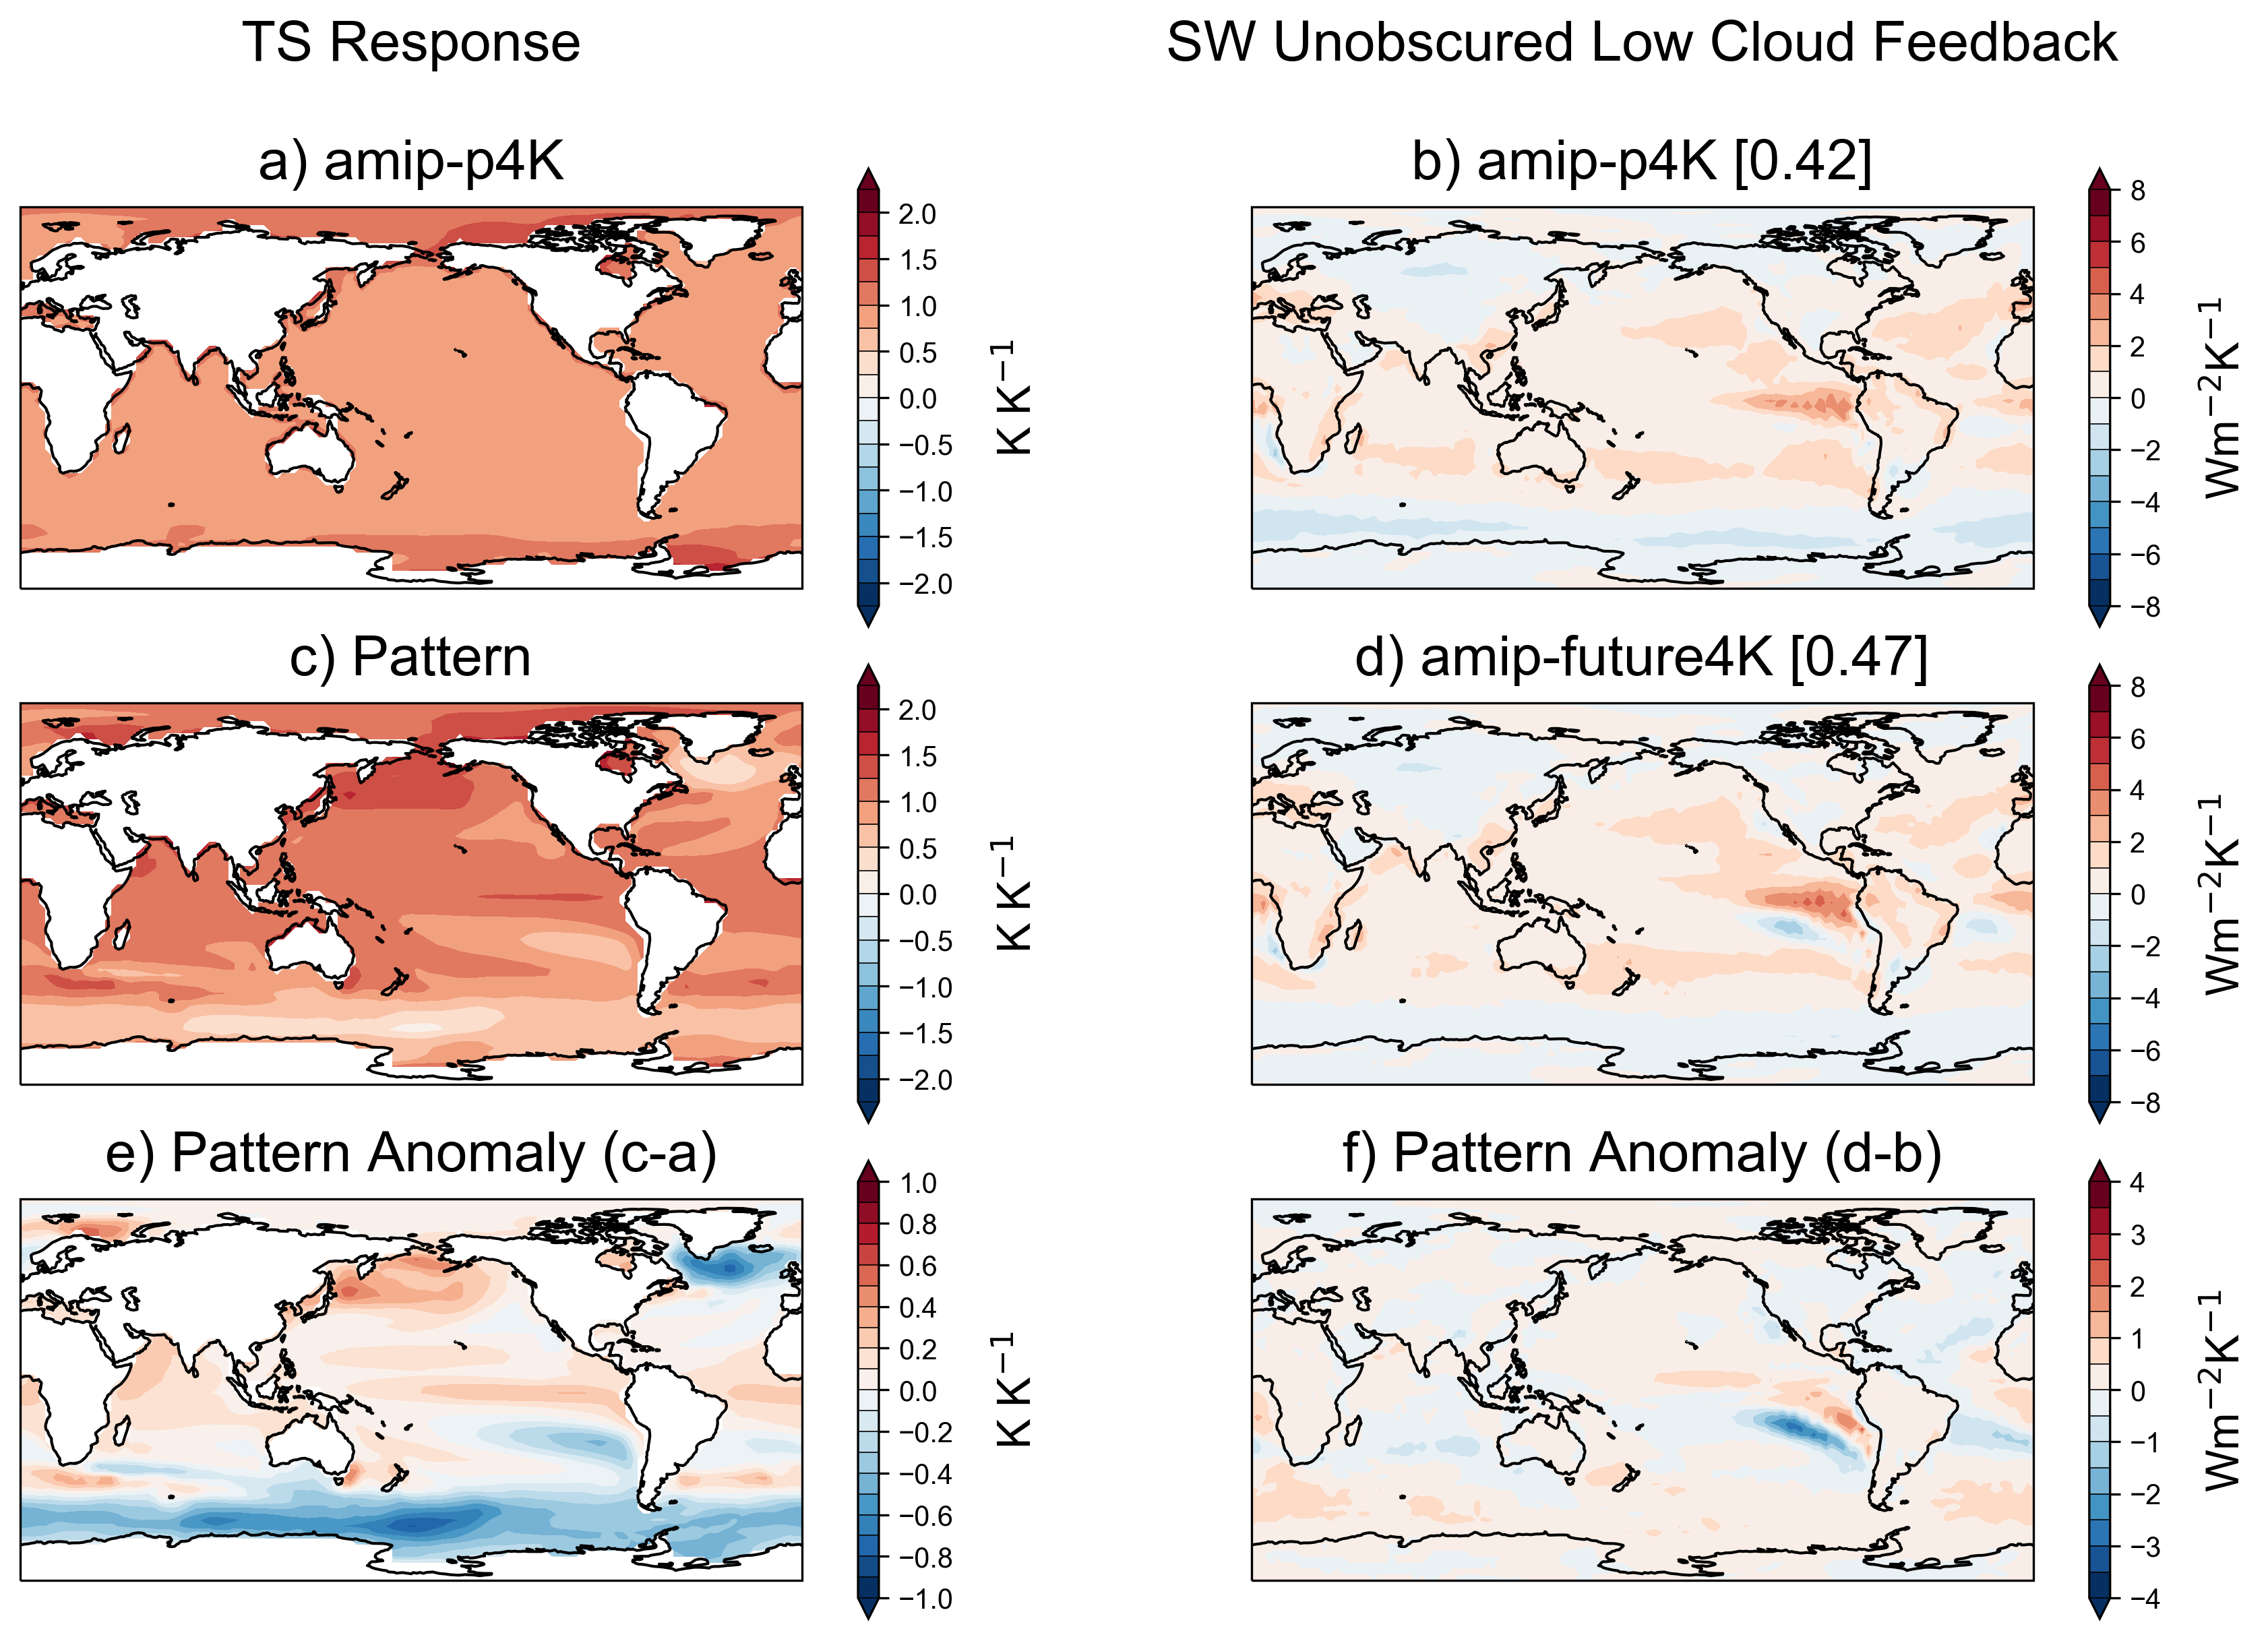

In [42]:
fig = plt.figure(figsize=(15,9),dpi=300)

#Uniform SST change
ax = plt.subplot(321,projection=ccrs.PlateCarree(central_longitude=180))
#ax.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax.set_title('TS Response\n\na) amip-p4K',fontsize=20,pad=10)
im = ax.contourf(lon_cyc,lat,\
    dSST_plot['CanESM5_p2']['Uniform']/dSST_gam['CanESM5_p2']['Uniform'],\
                   SST_bounds,cmap=cmap,norm=SST_norm,extend='both')
ax.coastlines()
cbar_1 = plt.colorbar(im,ticks=SST_bounds_ticks,drawedges=True,shrink=1.2)
cbar_1.set_label('K K$^{-1}$',labelpad=15,fontsize=16)
#plt.text(0.15,1.3,'2SST',fontsize=20,transform = ax.transAxes)

#Uniform SW Cloud amount feedback
ax1 = plt.subplot(322,projection=ccrs.PlateCarree(central_longitude=180))
#ax1.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax1.set_title('SW Unobscured Low Cloud Feedback\n\nb) amip-p4K [{}]'.\
              format(round(data_sw_gam['CanESM5_p2']['Low_unobscured']['amip-p4K'],2)),\
              fontsize=20,pad=10)
im1 = ax1.contourf(lon_cyc,lat,data_sw_plot['CanESM5_p2']['Low_unobscured']['amip-p4K'],\
                   FB_bounds,cmap=cmap,norm=FB_norm,extend='both')
ax1.coastlines()
cbar_1 = plt.colorbar(im1,ticks=FB_bounds_ticks,drawedges=True,shrink=1.2)
cbar_1.set_label('Wm$^{-2}$K$^{-1}$',labelpad=15,fontsize=16)
#plt.text(0.2,1.3,'5SST',fontsize=40,transform = ax1.transAxes)

#Pattern SST change
ax2 = plt.subplot(323,projection=ccrs.PlateCarree(central_longitude=180))
#ax2.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax2.set_title('c) Pattern',fontsize=20,pad=10)
im2 = ax2.contourf(lon_cyc,lat,\
    dSST_plot['CanESM5_p2']['Pattern']/dSST_gam['CanESM5_p2']['Pattern'],\
                   SST_bounds,cmap=cmap,norm=SST_norm,extend='both')
ax2.coastlines()
cbar_2 = plt.colorbar(im2,ticks=SST_bounds_ticks,drawedges=True,shrink=1.2)
cbar_2.set_label('K K$^{-1}$',labelpad=15,fontsize=16)
#plt.text(0.15,1.3,'2SST',fontsize=20,transform = ax.transAxes)

#Pattern SW Cloud amount feedback
ax3 = plt.subplot(324,projection=ccrs.PlateCarree(central_longitude=180))
#ax3.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax3.set_title('d) amip-future4K [{}]'.\
              format(round(data_sw_gam['CanESM5_p2']['Low_unobscured']['amip-future4K'],2)),fontsize=20,pad=10)
im3 = ax3.contourf(lon_cyc,lat,data_sw_plot['CanESM5_p2']['Low_unobscured']['amip-future4K'],\
                   FB_bounds,cmap=cmap,norm=FB_norm,extend='both')
ax3.coastlines()
cbar_3 = plt.colorbar(im3,ticks=FB_bounds_ticks,drawedges=True,shrink=1.2)
cbar_3.set_label('Wm$^{-2}$K$^{-1}$',labelpad=15,fontsize=16)  

#Pattern SST change
ax4 = plt.subplot(325,projection=ccrs.PlateCarree(central_longitude=180))
#ax4.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax4.set_title('e) Pattern Anomaly (c-a)',fontsize=20,pad=10)
im4 = ax4.contourf(lon_cyc,lat,\
    (dSST_plot['CanESM5_p2']['Pattern']/dSST_gam['CanESM5_p2']['Pattern'])\
    -(dSST_plot['CanESM5_p2']['Uniform']/dSST_gam['CanESM5_p2']['Uniform']),\
                   dSST_bounds,cmap=cmap,norm=dSST_norm,extend='both')
ax4.coastlines()
cbar_4 = plt.colorbar(im4,ticks=dSST_bounds_ticks,drawedges=True,shrink=1.2)
cbar_4.set_label('K K$^{-1}$',labelpad=15,fontsize=16)

#Pattern SW Cloud amount feedback
ax5 = plt.subplot(326,projection=ccrs.PlateCarree(central_longitude=180))
#ax5.set_extent([-100, 30, -60, 60], crs=ccrs.PlateCarree())
ax5.set_title('f) Pattern Anomaly (d-b)',fontsize=20,pad=10)
im5 = ax5.contourf(lon_cyc,lat,(data_sw_plot['CanESM5_p2']['Low_unobscured']['amip-future4K']-\
                   data_sw_plot['CanESM5_p2']['Low_unobscured']['amip-p4K']),\
                   dFB_bounds,cmap=cmap,norm=dFB_norm,extend='both')
ax5.coastlines()
#g = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='k', linestyle='-')
#g.xlabels_top = False
#g.xlabels_bottom = False
#g.ylabels_left = False
#g.ylabels_right = False
#g.xlines = False
#g.ylocator = mticker.FixedLocator([-30, 30])
cbar_5 = plt.colorbar(im5,ticks=dFB_bounds_ticks,drawedges=True,shrink=1.2)
cbar_5.set_label('Wm$^{-2}$K$^{-1}$',labelpad=15,fontsize=16) 


plt.subplots_adjust(wspace=0.1,hspace=0.3)

#plt.savefig('CLD_Custom_5SST_CLDfb.png',bbox_inches='tight')